In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from environment import State, ManipulatorEnv
import sys
from rrt import RRTPlanner
from angle_util import *
import cv2
from matplotlib.animation import FuncAnimation


np.random.seed(42)

with open('data.pickle', 'rb') as tmp:
        data = pickle.load(tmp)


start_state = State(np.array(data['start_state']))
goal_state = State(np.array(data['goal_state']))


# data["start_state"]
# data["goal_state"]

env_start = ManipulatorEnv(obstacles=np.array(data['obstacles']),
                     initial_state=start_state,
                     collision_threshold=data['collision_threshold'])
env_end = ManipulatorEnv(obstacles=np.array(data['obstacles']),
                     initial_state=goal_state,
                     collision_threshold=data['collision_threshold'])

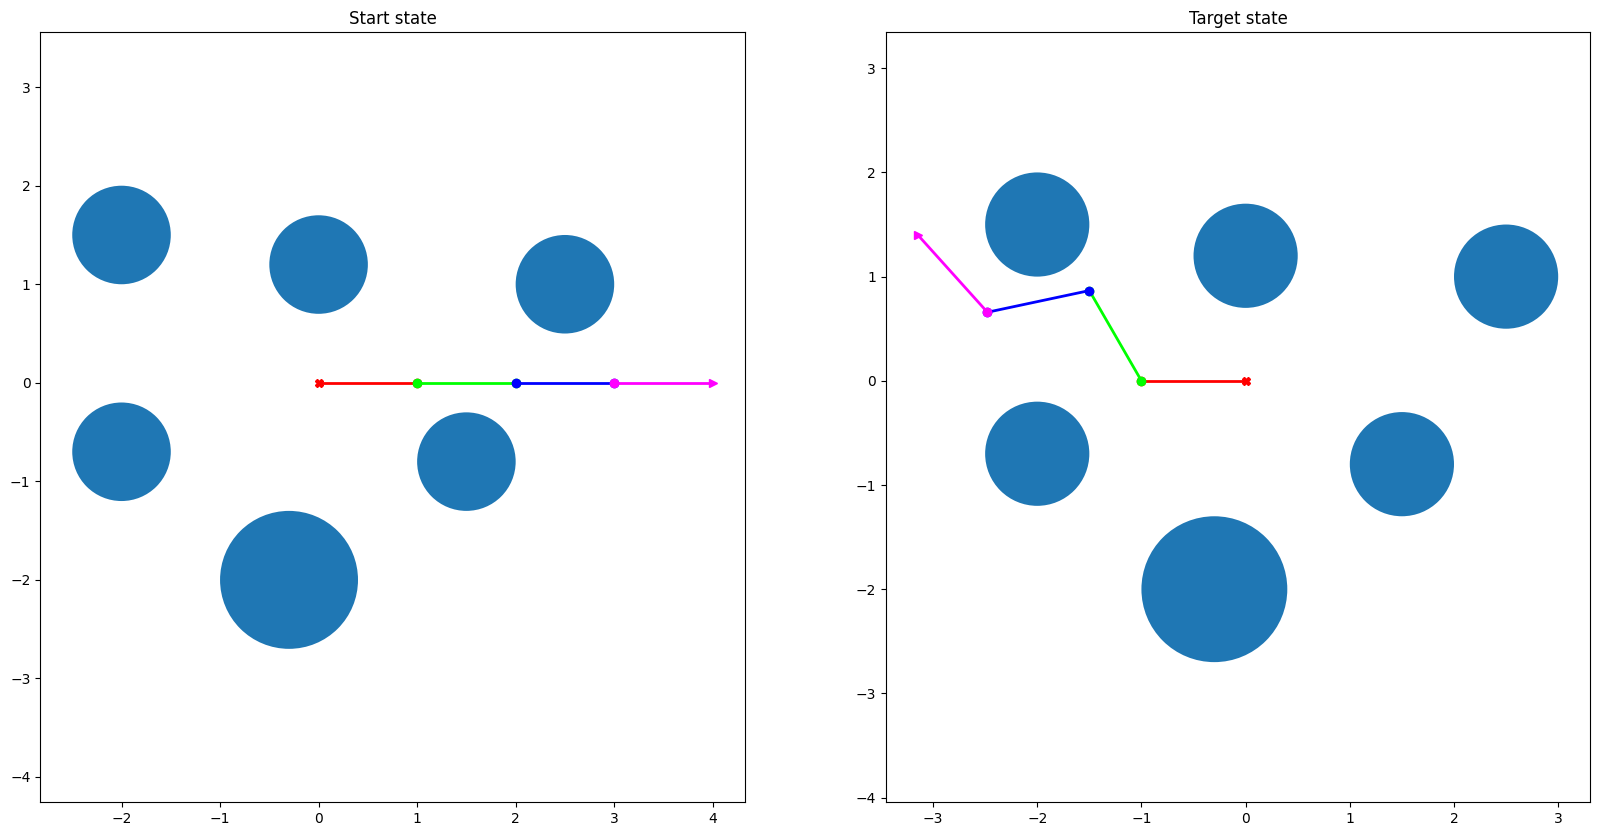

In [2]:
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
env_start.render(plt_show=False)
plt.title('Start state')
plt.subplot(1, 2, 2)
env_end.render(plt_show=False)
plt.title('Target state')
plt.show()

The continuous space allows for an infinite number of possible configurations (but it makes task more difficult)

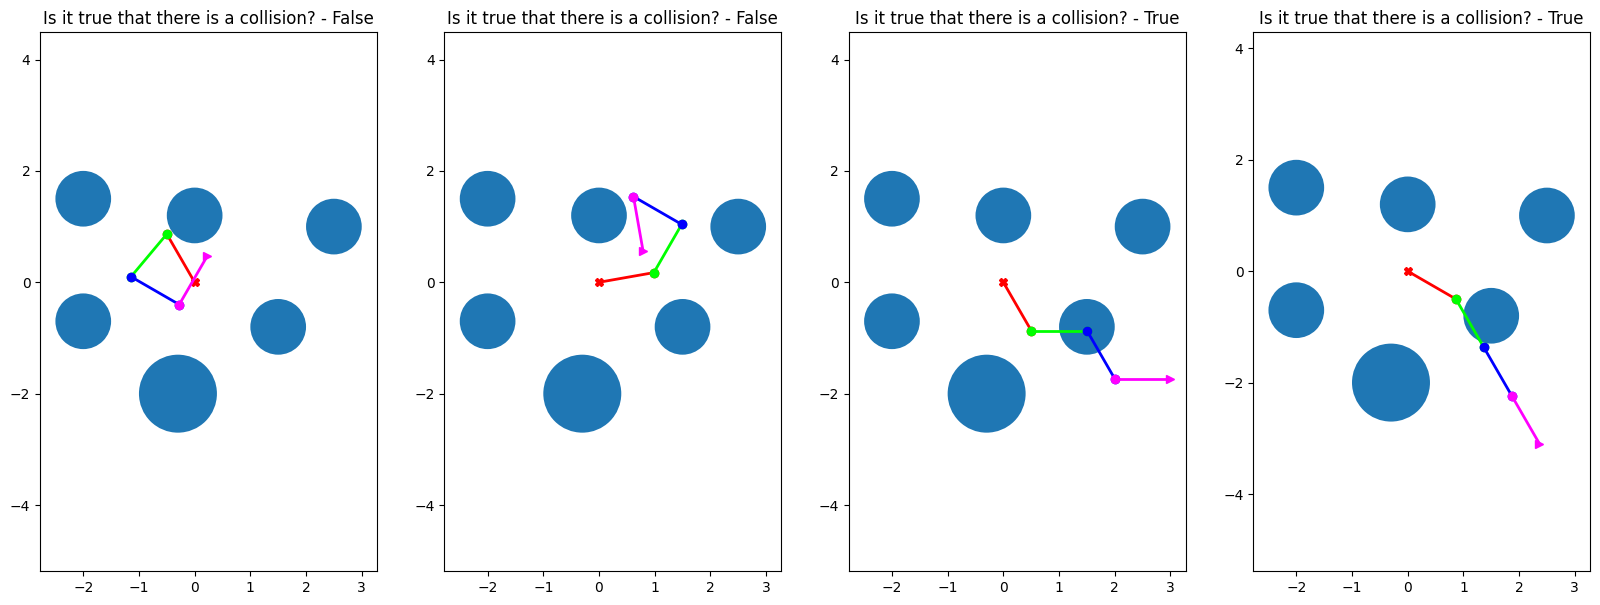

In [3]:
plt.figure(figsize = (20, 7))
states = [[120, 110, 100, 90], [10, 50, 90, 130], [-60, 60, -60, 60], [-30, -30, 0, 0]]
for i in range(4):
    plt.subplot(1, 4, i+1)
    state =  State(np.array(states[i]))
    env = ManipulatorEnv(obstacles=np.array(data['obstacles']),
                     initial_state=state,
                     collision_threshold=data['collision_threshold'])
    env.render(plt_show=False)
    plt.title(f'Is it true that there is a collision? - {env.check_collision(state)}')

Two examples of collision and non-collision

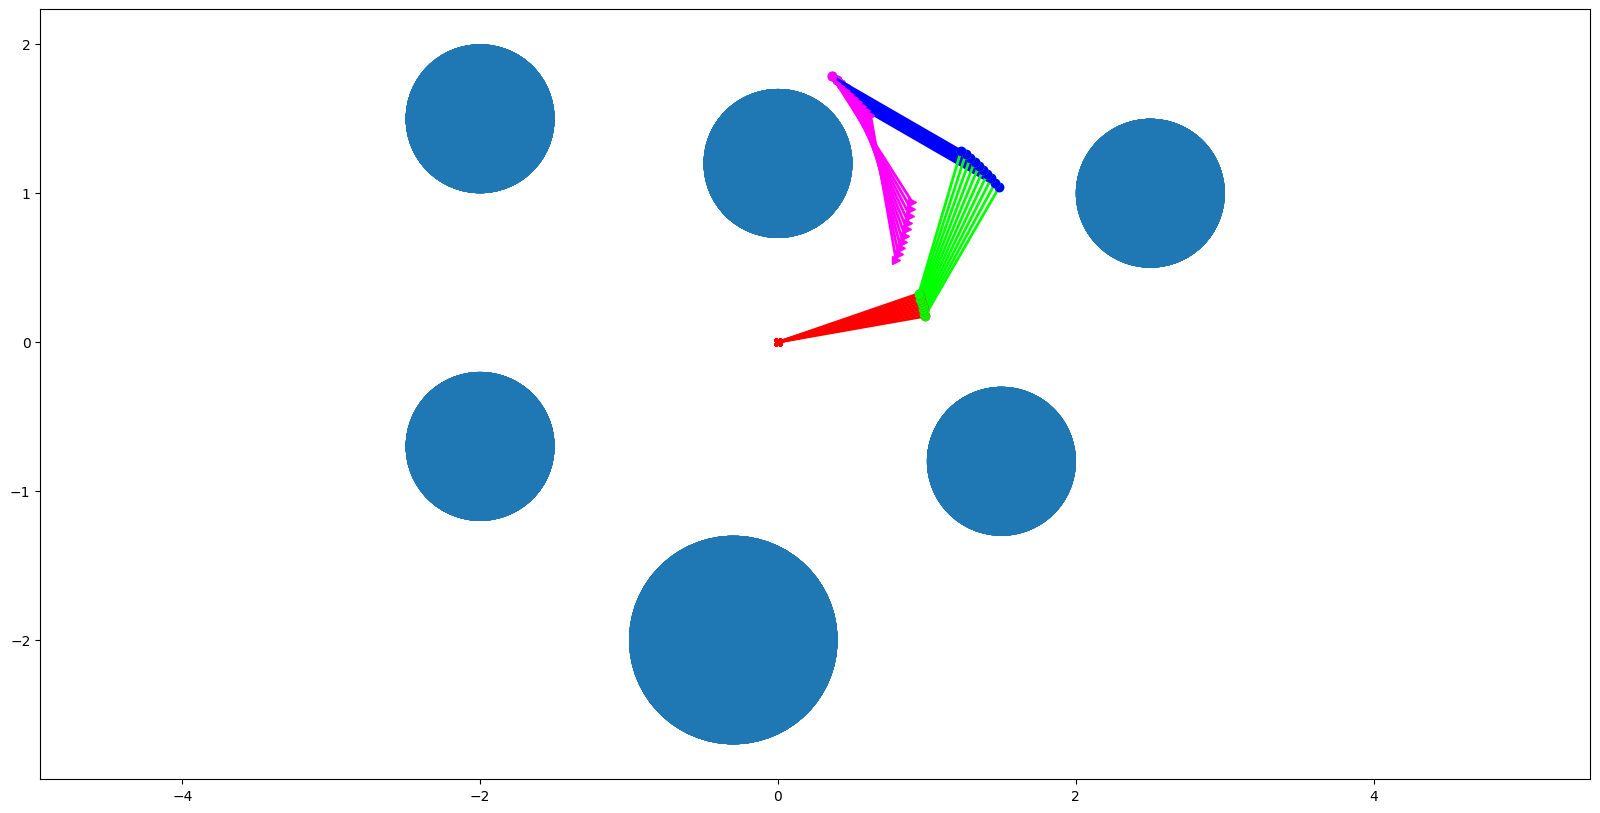

In [4]:
q = np.array([10, 50, 90, 130])
pert = np.array([10, 5, -15, 25])
q_G = q + pert
n = 10
tmp_steps = np.array(angle_linspace(q, q_G, n))
plt.figure(figsize = (20, 10))
no_collision = True
for i in range(n):
    state = State(tmp_steps[i])
    if env.check_collision(state):
        no_collision = False
    env = ManipulatorEnv(obstacles=np.array(data['obstacles']), initial_state=state,
                         collision_threshold=data['collision_threshold'])
    env.render(plt_show=False)

Checking my eyes

In [5]:
if no_collision:
    print('no collision')

no collision


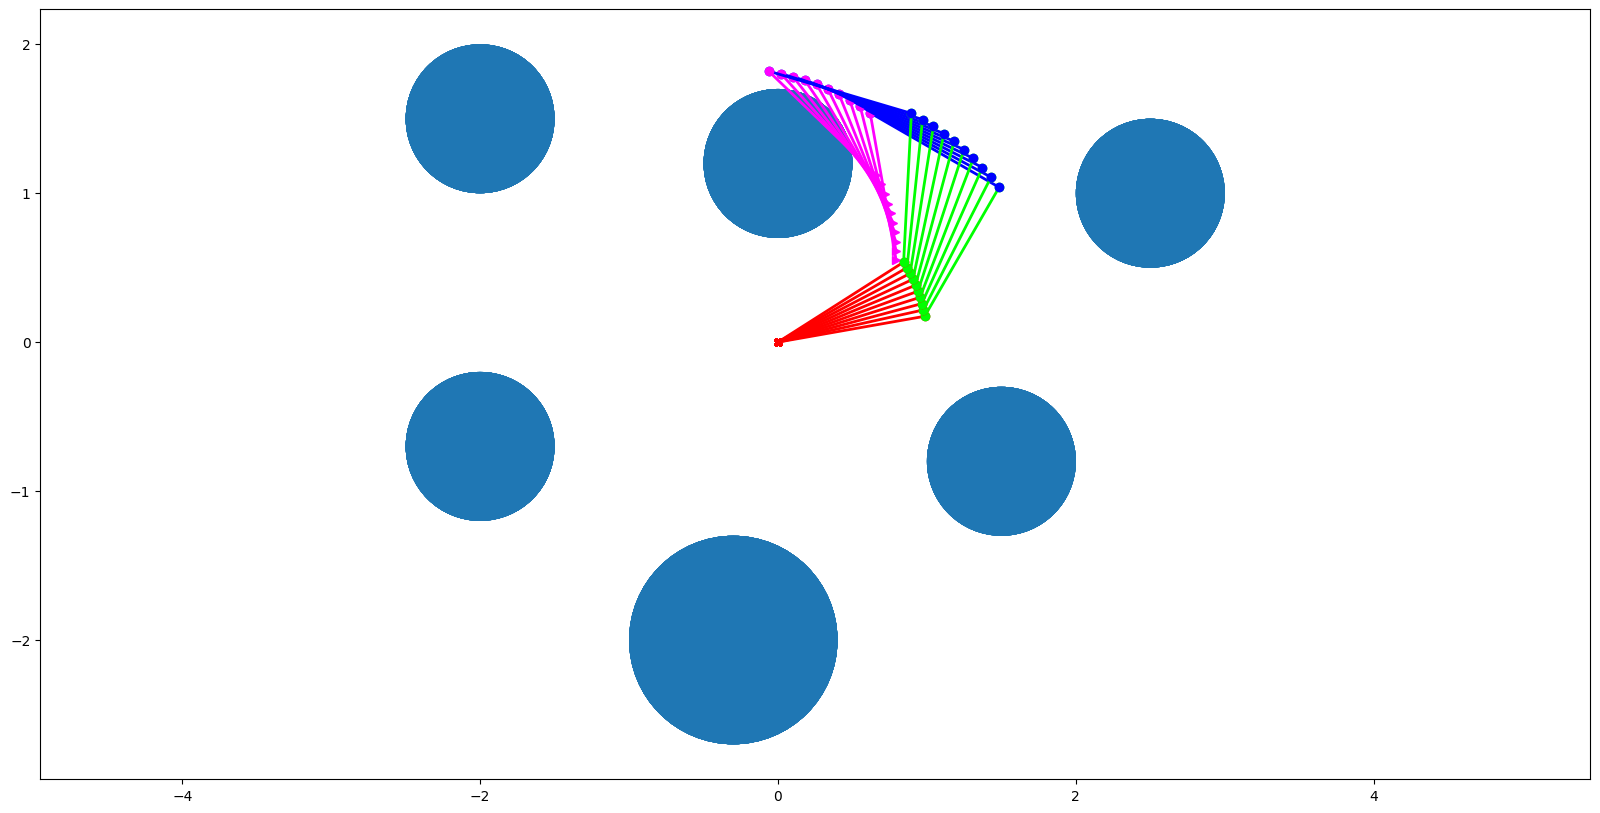

In [6]:
q = np.array([10, 50, 90, 130])
pert = np.array([25, 5, -15, 25])
q_G = q + pert
n = 10
tmp_steps = np.array(angle_linspace(q, q_G, n))
plt.figure(figsize = (20, 10))
no_collision = True
for i in range(n):
    state = State(tmp_steps[i])
    if env.check_collision(state):
        no_collision = False
    env = ManipulatorEnv(obstacles=np.array(data['obstacles']), initial_state=state,
                         collision_threshold=data['collision_threshold'])
    env.render(plt_show=False)

Checking my eyes

In [7]:
if no_collision == False:
    print('There is a collision')

There is a collision


In [8]:
env = ManipulatorEnv(obstacles=np.array(data['obstacles']),
                         initial_state=start_state,
                         collision_threshold=data['collision_threshold'])

planner = RRTPlanner(env, lambda x,y: np.linalg.norm(angle_difference(x,y), ord = 1))
# print(planner)
result = planner.plan(start_state, goal_state)
# print(result)
if not isinstance(result, str):
    plan, num_iterations = result['plan'], result['iterations']
    print('length', len(plan))
    print('iterations', num_iterations)
    print('number of states', result['nodes_n'])
else:
    print(result)

length 165
iterations 676
number of states 1710


Downloading video

In [9]:
fig = plt.figure()
ax = fig.add_subplot()

def AnimationFunction(frame):
    ax.clear()
    env.state = plan[frame]
    env.ax_render(ax)
    ax.set_xlim()
    ax.set_ylim()

mp4 = FuncAnimation(fig, AnimationFunction, frames=len(plan), interval=30)
mp4.save('solve_4R.mp4', writer='ffmpeg')
plt.close()

In [18]:
# from tqdm import tqdm

np.random.seed(42)
result = planner.plan(start_state, goal_state)
if not isinstance(result, str):
    plan, num_iterations = result['plan'], result['iterations']
    print('length', len(plan))
    print('iterations', num_iterations)
    print('number of states', result['nodes_n'])
else:
    print(result)

length 97
iterations 1492
number of states 1810


In [19]:
np.random.seed(1)
result = planner.plan(start_state, goal_state)
if not isinstance(result, str):
    plan, num_iterations = result['plan'], result['iterations']
    print('length', len(plan))
    print('iterations', num_iterations)
    print('number of states', result['nodes_n'])
else:
    print(result)

length 87
iterations 2072
number of states 2576


In [20]:
np.random.seed(11111)
result = planner.plan(start_state, goal_state)
if not isinstance(result, str):
    plan, num_iterations = result['plan'], result['iterations']
    print('length', len(plan))
    print('iterations', num_iterations)
    print('number of states', result['nodes_n'])
else:
    print(result)

length 121
iterations 2804
number of states 3424


Well, my way visually is quite good but there some repetitions (that's why it's not so good). I ran code many times and the pattern is similar: you get random results (obviously), often you reduce you length but increase iterations and numver of states.

I add exponential declining in weight (x+x/2+x/4+x/8=1 => x = 8/15)

In [12]:
def angle_distance(x,y):
    delta = np.abs(angle_difference(x,y))
    return delta[0]*8/15 + delta[1]*4/15 + delta[2]*2/15 + delta[3]/15

planner = RRTPlanner(env, angle_distance)

result = planner.plan(start_state, goal_state)
if not isinstance(result, str):
    plan, num_iterations = result['plan'], result['iterations']
    print('length', len(plan))
    print('iterations', num_iterations)
else:
    print(result)

length 44
iterations 3296


I have much less length, but the cost is increasing numbers of iterations. This happens because we want to find shorter way but we need to 'adjust' last parts

In [15]:
for j in tqdm([5 + i for i in range(14)]):
    np.random.seed(42)
    planner = RRTPlanner(env, lambda x,y: np.linalg.norm(angle_difference(x,y), ord = 1), max_angle_step = j)
    result = planner.plan(start_state, goal_state)

    if not isinstance(result, str):
        plan, num_iterations = result['plan'], result['iterations']
        print('length', len(plan))
        print('iterations', num_iterations)
        print('number of states', result['nodes_n'])
    else:
        print(result)

  7%|▋         | 1/14 [00:27<05:53, 27.17s/it]

length 392
iterations 676
number of states 3095


 14%|█▍        | 2/14 [03:10<21:23, 106.99s/it]

length 239
iterations 1795
number of states 6519


 21%|██▏       | 3/14 [04:07<15:26, 84.20s/it] 

length 242
iterations 1022
number of states 3311


 29%|██▊       | 4/14 [04:20<09:21, 56.16s/it]

length 224
iterations 556
number of states 1488


 36%|███▌      | 5/14 [04:36<06:16, 41.84s/it]

length 199
iterations 676
number of states 1741


 43%|████▎     | 6/14 [04:52<04:24, 33.04s/it]

length 165
iterations 676
number of states 1710


 50%|█████     | 7/14 [05:52<04:51, 41.69s/it]

length 178
iterations 1623
number of states 2930


 57%|█████▋    | 8/14 [06:12<03:29, 34.96s/it]

length 171
iterations 837
number of states 1718


 64%|██████▍   | 9/14 [06:32<02:31, 30.35s/it]

length 171
iterations 837
number of states 1551


 71%|███████▏  | 10/14 [07:21<02:24, 36.07s/it]

length 126
iterations 1492
number of states 2477


 79%|███████▊  | 11/14 [07:23<01:16, 25.44s/it]

length 114
iterations 237
number of states 391


 86%|████████▌ | 12/14 [07:42<00:47, 23.50s/it]

length 93
iterations 944
number of states 1449


 93%|█████████▎| 13/14 [07:46<00:17, 17.58s/it]

length 86
iterations 488
number of states 534


100%|██████████| 14/14 [08:23<00:00, 35.93s/it]

length 97
iterations 1492
number of states 1810


Smaller steps are too slowly computing, I started from 5 to 18. Way more big steps are obviously bad (you can't easily pass obstacles) but some increasing of the step can help as you can see in results